# Convolutions based FE loss function implementation

## 1. Introduction

In this workbook, we cover the usage of DiffNets to solve Poisson's Equation. The Poisson equation for the scalar field $u({\bf x})$ can be written as

$$
\begin{align}
-\nabla \cdot (\nu({\bf x}) \nabla u({\bf x})) &= 0 \ \textrm{ in } D\\
u &= 1 \ \textrm{ on } x=0,\\
u &= 0 \ \textrm{ on } x=1,\\
\frac{\partial u}{\partial n} &=0 \ \textrm{ on } y=0 \textrm { and } y=1
\end{align}
$$

where, the domain $D = [0,1]^2$ is the unit square; $n$ represents outward unit normal vector, ${\bf x} = (x,y)$ represents the independent variables and $\nu({\bf x})$ represents the *diffusivity* (or *permeability*) of the medium. In this example, $\nu = \nu({\bf x}, \omega)$ where $\omega$ is a parameter that can be randomly chosen from a parameter space $\Omega$. Thus, by varying $\omega$, we can obtain different $\nu$ fields, each of which then renders a different solution to the above Poisson's equation. This means, every time a different $\omega$ is chosen, the solution needs to be obtained by solving the equation. But using DiffNet, we can train a model offline one time and learn the correct mapping so that we do not need to solve the equation again as long as $\omega$ is chosen from the same parameter space $\Omega$. Therefore, we wish to train a DiffNet $G_{nn}$ such that it is able to construct the correct mapping between the input space of $S^d$ and the space of the solutions $U^d$.

For the purpose of this tutorial, it suffices to assume that the logarithm of $\nu({\bf x}; \omega)$ can be expressed in summation form as follows:
$$
\begin{align}
\ln(\nu({\bf x}; \omega)) &= \sum_{i=1}^{m}\omega_i \xi_i(x)\eta_i(y)\\
\text{or},\  \nu({\bf x}; \omega) &= \exp \Big(\sum_{i=1}^{m}\omega_i \xi_i(x)\eta_i(y)\Big)
\end{align}
$$
where $\xi$ and $\eta$ are known functions of $x$ and $y$ respectively. See Sec. 2.2.1 of [this paper](https://arxiv.org/abs/2104.14538) for more details. We choose $m=6$ for this example and assume that each $\omega_i$ is chosen from $[-3,3]$ interval randomly. Thus, $\omega\in\Omega = [-3,3]^6$.

## 2. DiffNet
A trained DiffNet can take a full field of diffusivity (or forcing) and map it to the full field solution. For example, in the below schematic, we see a trained DiffNet $G_{nn}$ takes a matrix $S^d$ (numerical version of $\nu({\bf x})$) as input and map it to another matrix $U^d$ (approximated version of $u({\bf x}))$:
![](https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/xdiffnet-scheme.png)
Both $S^d$ and $U^d$ are matrices (or images) of the same size ($6\times 6$ or, $5\times 5$ "finite elements"). The neural network $G_{nn}$ can be thought of as a having a UNet architecture as below:
![](https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/UNetArch.png)

Suppose the network parameters are given by $\theta$. Then, given such discretized representations of $S^d$ and $U^d$, DiffNet solves the Poisson's equation by minimizing the integral loss function given by:
$$
J(\theta) = \frac{1}{N_s}\sum_{j=1}^{N_s} \int \nu_j({\bf x}; \omega)|\nabla u_j({\bf x}, \theta)|^2 d{\bf x},
$$
where $u_j = G_{nn}(\nu_j, \theta)$, i.e., the solution corresponding to the $j^{th}$ sample of diffusivity.

The solution is then given by:
$$
\begin{align}
\theta^* &= \arg\min J(\theta),\\
u &= G_{nn}(\nu, \theta^*).
\end{align}
$$

We minimize the loss function $J(\theta)$ using Adam optimizer.

The DiffNet library provides in-built capability to approximate full field solutions and Lagrangian basis functions as convolution kernels along with evaluations on Gauss quadrature points. To use these features for solving the Poisson's equation, we need to implement two classes:
1. A dataset class `KLSum` (derived from `torch.utils.Dataset`): to implement the diffusivity, forcing and the boundary conditions.
2. An equation class `Poisson` (derived from `DiffNet.DiffNetFEM`): to implement the loss function, training step, optimizer configuration, query step etc.

## 3. Imports
We begin with few imports

In [1]:
import os
import sys
import json
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan_old import GoodGenerator
from DiffNet.networks.autoencoders import AE
from DiffNet.DiffNetFEM import DiffNet2DFEM
from DiffNet.datasets.parametric.klsum import KLSumStochastic
from DiffNet.datasets.single_instances.klsum import Dataset

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42


## 4. Dataset class
Suppose we discretize the 2D domain into regularly spaced $N\times N$ grid points (i.e., $(N-1)\times(N-1)$ finite elements.

The `KLSum` class holds the given "input data" of the equation, i.e., the diffusivity ($\nu$) and the boundary conditions ($u_{\partial D}$). The important thing to note here is that, since DiffNet is based on full-field calculations, all three of these data need to be stored in tensor format. Specifically, since the current equation is defined on a 2D square domain, we store each of $\nu$, $f$ and $u_{\partial D}$ in 2D matrices of size $N\times N$.

In [2]:
from tqdm import tqdm
from torch.utils import data
from DiffNet.gen_input_calc import generate_diffusivity_tensor


class KLSum(data.Dataset):
    'PyTorch dataset for sampling coefficients'
    def __init__(self, domain_size=64, kl_terms=6, filename='', coeff_array=[]):
        """
        Initialization
        """
        if filename != '':
            self.coeffs = np.load(filename)
        else:
            if coeff_array != []:
                self.coeffs = coeff_array
            else:
                raise ValueError("Either filename or an array must be provided")
        self.domain_size = domain_size
        self.kl_terms = kl_terms
        self.dataset = []
        
        print('loading dataset')
        for coeff in tqdm(self.coeffs[:100]):
            domain = generate_diffusivity_tensor(coeff, output_size=self.domain_size, n_sum_nu=kl_terms).squeeze()
            # bc1 will be source, u will be set to 1 at these locations
            bc1 = np.zeros_like(domain)
            bc1[:,0] = 1

            # bc2 will be sink, u will be set to 0 at these locations
            bc2 = np.zeros_like(domain)
            bc2[:,-1] = 1

            self.dataset.append(np.array([domain,bc1,bc2]))
        self.dataset = np.array(self.dataset)
        self.n_samples = self.dataset.shape[0]

    def __len__(self):
        'Denotes the total number of samples'
        return self.n_samples

    def __getitem__(self, index):
        'Generates one sample of data'
        inputs = self.dataset[index]
        forcing = np.zeros_like(self.dataset[index][0])
        return torch.FloatTensor(inputs), torch.FloatTensor(forcing).unsqueeze(0)



## 5. Training data
As discussed above, the formula for calculating $\nu$ for a particular $\omega$ is known to us. So, to create the training dataset of multiple $\nu$, we essentially need to create a training dataset of multiple $\omega$ chosen from the 6-dimensional space $\Omega$ and thereafter calculate $\nu$ at each of those $\omega$. Before defining the 

In [3]:
!wget https://github.com/rocketmlhq/sciml/raw/main/05_DiffNets/sobol_6d.npy

--2021-11-14 18:38:06--  https://github.com/rocketmlhq/sciml/raw/main/05_DiffNets/sobol_6d.npy
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/sobol_6d.npy [following]
--2021-11-14 18:38:07--  https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/sobol_6d.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3145856 (3.0M) [application/octet-stream]
Saving to: ‘sobol_6d.npy.7’

100%[======================================>] 3,145,856   --.-K/s   in 0.1s    

2021-11-14 18:38:07 (27.5 MB/s) - ‘sobol_6d.npy.7’ saved [3145856/3145856]



## 6. Equation class

Now we need to define the equation class `Poisson` that inherits the `DiffNet.DiffNetFEM` class which in turn inherits the `LightningModule` class from `pytorch_lightning.core`. The main purpose of `Poisson` is to implement the training step and the loss function along with optimizer configurations (if necessary). Let us discuss them one by one:
* `training_step`: this function will be called by `PytorchLightning` every training step with an input `batch`. This `batch` represents the data for a minibatch and is obtained by `PytorchLightning` by calling the `__getitem__` function in the `DataRectangle` class.
* `loss(u, I, f)`: the loss function can be implemented in many ways, but essentially takes the data of the equation and calculates the loss value. In this implementation `loss` takes the currently predicted field `u` and the other inputs (BC, nu, f). Inside this function, we evaluate the integral $J(u) = \frac{1}{N_s}\sum_{i=1}^{N_s} \int \nu_i|\nabla u_i|^2 d{\bf x}$. This is an important step and is done as follows:
    * Extract `nu` and `bc` from `imputs_tensor`
    * Apply the boundary conditions on `u` using the boundary masks (i.e., `bc1` and `bc2` that contain zeros in the interior points, and ones on the boundary points.
    * Now we need to evaluate the values in the integrand at the Gauss quadrature points. Given any field `g` on the grid points, we can evaluate `g` on **_all_** the Gauss quadrature points in $D$, by calling `g_GP = self.gauss_pt_evaluation(g)`. The derivatives of `g` can be evaluated on the Gauss points directly by `g_x_GP = self.gauss_pt_evaluation_der_x(g)` and `g_y_GP = self.gauss_pt_evaluation_der_y(g)` for the $x$ and $y$ derivative respectively.
    * Once all the integration values are evaluated on the quadrature points, the next step is to simply write down the integration using the quadrature data, exactly as it appears in the loss formula.
* Along with the above two functions, some other auxiliary functions can be added to this class as needed, e.g., `do_query`, `plot_contours`, `on_epoch_end` etc.
* `on_epoch_end` is called by `PytorchLightning` at the end of each epoch during training. We can plot the current `u` vlaue at the end of each epoch by implementing this function accordingly.

In [4]:
class Poisson(DiffNet2DFEM):
    """docstring for Poisson"""
    def __init__(self, network, dataset, **kwargs):
        super(Poisson, self).__init__(network, dataset, **kwargs)

    def loss(self, u, inputs_tensor, forcing_tensor):

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]

        # apply boundary conditions
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)


        nu_gp = self.gauss_pt_evaluation(nu)
        f_gp = self.gauss_pt_evaluation(f)
        u_gp = self.gauss_pt_evaluation(u)
        u_x_gp = self.gauss_pt_evaluation_der_x(u)
        u_y_gp = self.gauss_pt_evaluation_der_y(u)

        transformation_jacobian = self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(nu_gp)
        res_elmwise = transformation_jacobian * (nu_gp * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp))
        res_elmwise = torch.sum(res_elmwise, 1) 

        # transformation_jacobian = (0.5 * self.h)**2 * self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(nu_gp)
        # res_elmwise = 0.5 * transformation_jacobian * (nu_gp * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp))
        # res_elmwise = torch.sum(res_elmwise, 1) 

        loss = torch.mean(res_elmwise)
        return loss

    def forward(self, batch):
        inputs_tensor, forcing_tensor = batch
        u = self.network(inputs_tensor[:,0:1,:,:])
        return u, inputs_tensor, forcing_tensor

    def training_step(self, batch, batch_idx):
        u, inputs_tensor, forcing_tensor = self.forward(batch)
        loss_val = self.loss(u, inputs_tensor, forcing_tensor).mean()
        return {"loss": loss_val}

    def training_step_end(self, training_step_outputs):
        loss = training_step_outputs["loss"]
        self.log('PDE_loss', loss.item())
        self.log('loss', loss.item())
        return training_step_outputs

    def configure_optimizers(self):
        lr = self.learning_rate
        # opts = [torch.optim.LBFGS(self.network.parameters(), lr=lr, max_iter=5)]
        opts = [torch.optim.Adam(self.network.parameters(), lr=lr)]
        # schd = []
        schd = [torch.optim.lr_scheduler.MultiStepLR(opts[0], milestones=[10,15,30], gamma=0.1)]
        return opts, schd
    
    def do_query(self, inputs, forcing):
        u, inputs_tensor, forcing_tensor = self.forward((inputs.type_as(next(self.network.parameters())), 
                                                         forcing.type_as(next(self.network.parameters()))))
        
        f = forcing_tensor.squeeze().detach().cpu() # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]        
        # process diffusivity
        k = nu.squeeze().detach().cpu()

        # apply boundary conditions
        u = u[:,0:1,:,:]
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)
        u = u.squeeze().detach().cpu()
        
        return u, k, f
    
    def plot_contours(self,k,u):
        num_sample = k.shape[0]
        plt_num_row = k.shape[0]
        plt_num_col = 2
        fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2*plt_num_row),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax_row in axs:
            for ax in ax_row:
                ax.set_xticks([])
                ax.set_yticks([])              
        
        # print(np.linalg.norm(diff.flatten())/self.domain_size)
#         im = axs[0].imshow(k,cmap='jet')
#         fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
#         im = axs[1].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
#         fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
#         plt.show()
        
        for idx in range(num_sample):
            im0 = axs[idx][0].imshow(k[idx,:,:],cmap='jet')
            fig.colorbar(im0, ax=axs[idx,0]); axs[idx,0].set_title(r'$\nu$')
            im1 = axs[idx][1].imshow(u[idx,:,:],cmap='jet')
            fig.colorbar(im1, ax=axs[idx,1]); axs[idx,1].set_title(r'$u_{\theta}$')  
    
    def on_epoch_end(self):
        num_query = 6
        plt_num_row = num_query
        plt_num_col = 2
        fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2*plt_num_col,1.2*plt_num_row),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax_row in axs:
            for ax in ax_row:
                ax.set_xticks([])
                ax.set_yticks([])
        
        self.network.eval()
        inputs, forcing = self.dataset[0:num_query]
        forcing = forcing.repeat(num_query,1,1,1)

        ub, inputs_tensor, forcing_tensor = self.forward((inputs.type_as(next(self.network.parameters())), forcing.type_as(next(self.network.parameters()))))
        
        loss = self.loss(ub, inputs_tensor, forcing_tensor[:,0:1,:,:])

        for idx in range(num_query):
            f = forcing_tensor # renaming variable
            
            # extract diffusivity and boundary conditions here
            nu = inputs_tensor[idx,0:1,:,:]
            u = ub[idx,0:1,:,:]
            bc1 = inputs_tensor[idx,1:2,:,:]
            bc2 = inputs_tensor[idx,2:3,:,:]

            # apply boundary conditions
            u = torch.where(bc1>0.5,1.0+u*0.0,u)
            u = torch.where(bc2>0.5,u*0.0,u)

            k = nu.squeeze().detach().cpu()
            u = u.squeeze().detach().cpu()

            im0 = axs[idx][0].imshow(k,cmap='jet')
            fig.colorbar(im0, ax=axs[idx,0])
            im1 = axs[idx][1].imshow(u,cmap='jet')
            fig.colorbar(im1, ax=axs[idx,1])  
        plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
        self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        plt.close('all')


## 7. Initializations

In [5]:
kl_terms = 6
domain_size = 32
LR = 1e-3
batch_size = 128
sample_size = 65536
sobol_file = 'sobol_'+str(kl_terms)+'d.npy'
max_epochs = 10
print("Max_epochs = ", max_epochs)

dataset = KLSum(domain_size=domain_size, kl_terms=kl_terms, filename=sobol_file)
# dataset = Dataset('../single_instance/example-coefficients.txt', domain_size=64)
network = AE(in_channels=1, out_channels=1, dims=16, n_downsample=2)
basecase = Poisson(network, dataset, batch_size=batch_size, domain_size=domain_size, learning_rate=LR)

# ------------------------
# 1 INIT TRAINER
# ------------------------
logger = pl.loggers.TensorBoardLogger('.', name="klsum_"+str(domain_size))
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(callbacks=[checkpoint],
    checkpoint_callback=True, logger=[logger,csv_logger],
    max_epochs=max_epochs, deterministic=True, profiler='simple')

  0%|          | 0/100 [00:00<?, ?it/s]

Max_epochs =  10
loading dataset


100%|██████████| 100/100 [00:00<00:00, 1257.53it/s]
GPU available: True, used: False
TPU available: False, using: 0 TPU cores


## 8. Training

In [6]:
# ------------------------
# 4 Training
# ------------------------
trainer.fit(basecase)

# ------------------------
# 5 SAVE NETWORK
# ------------------------
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))


  | Name      | Type          | Params
--------------------------------------------
0 | network   | AE            | 264 K 
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
264 K     Trainable params
96        Non-trainable params
264 K     Total params
1.058     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it, loss=5.57e+04, v_num=2_2]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  15.038         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1.4951         	|10             	|  14.951         	|  99.417         	|
on_epoch_end                       	|  0.87864        	|10             	|  8.7864         	|  58.426         	|
run_training_batch                 	|  0.55443        	|10             	|  5.5443         	|  36.868         	|
optimizer_step_and_closure_0       	|  0.55403        	|10             	|  5.5403         	|  36.841         	|
training_step_and_backward         

## 9. Query

100%|██████████| 5/5 [00:00<00:00, 1226.84it/s]

loading dataset


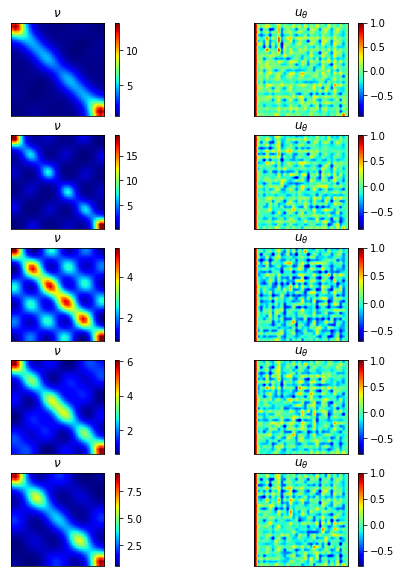

In [7]:
query_array = np.random.rand(5,6) # five samples of size 6
dataset = KLSum(domain_size=domain_size, kl_terms=kl_terms, filename='', coeff_array=query_array)
# dataset = Dataset('../single_instance/example-coefficients.txt', domain_size=64)
network = AE(in_channels=1, out_channels=1, dims=16, n_downsample=2)
basecase = Poisson(network, dataset, batch_size=batch_size, domain_size=domain_size, learning_rate=LR)

inputs, forcing = basecase.dataset[0:5]
u, nu, f = basecase.do_query(inputs, forcing) 

u.shape

# plot
basecase.plot_contours(nu.numpy(),u.numpy())